In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 161MB/s]


In [ ]:
# 使用左外連接合併，這樣假設bid的數據筆數多，它的數據不會遺失
data = pd.merge(data_bid, data_ask, on='Local time', how='left')

# 使用fillna填充NaN值，你可以使用特定值或其他策略，這裡我用0作為例子
data = data.fillna(0)

# 計算平均價格
data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
data['Average_High'] = (data['High_x'] + data['High_y']) / 2
data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
data['Total_Volume'] = data['Volume_x'] + data['Volume_y']
columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
data = data.drop(columns=columns_to_drop)

In [ ]:
# 計算價格和成交量的變化
data['Price_Change'] = data['Average_Close'].pct_change()
data['Volume_Change'] = data['Total_Volume'].pct_change()
# 創建未來三分鐘的收盤價欄位
data['Future_Close'] = data['Average_Close'].shift(-3)
data['three_minutes_Change'] = data['Future_Close'] - data['Average_Open']
# 處理缺失值和無窮大
data.replace([np.inf, -np.inf], np.nan, inplace=True)

missing_cols = data.columns[data.isnull().any()]
for col in missing_cols:
    data[col].fillna(data[col].median(), inplace=True)
# 嘗試使用完整的格式轉換日期時間
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.000 GMT+0800', errors='coerce')

# 對於剩下的非NaT項目，再次嘗試使用不帶GMT部分的基本格式轉換
data.loc[data['Local time'].isna(), 'Local time'] = pd.to_datetime(data[data['Local time'].isna()]['Local time'], format='%d.%m.%Y %H:%M:%S')
delete_condition = (
    ((data['Local time'].dt.weekday == 5) & (data['Local time'].dt.hour >= 5)) |
    (data['Local time'].dt.weekday == 6) |
    ((data['Local time'].dt.weekday == 0) & (data['Local time'].dt.hour < 5))
)
late_market_open_condition = (
    (data['Local time'].dt.weekday == 0) &
    (data['Local time'].dt.hour == 5) &
    (data['Local time'].dt.minute < 4) &
    (data['Total_Volume'] == 0)
)

# 組合上述兩個刪除條件
combined_delete_condition = delete_condition | late_market_open_condition
data.drop(data[combined_delete_condition].index, inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.head(23338))

               Local time  Average_Open  Average_High  Average_Low  \
0     2022-07-15 00:00:00      1.002740      1.002800     1.002660   
1     2022-07-15 00:01:00      1.002670      1.002745     1.002410   
2     2022-07-15 00:02:00      1.002730      1.002925     1.002635   
3     2022-07-15 00:03:00      1.002810      1.003210     1.002795   
4     2022-07-15 00:04:00      1.003210      1.003220     1.002900   
...                   ...           ...           ...          ...   
23333 2022-08-06 04:58:00      1.018080      1.018285     1.017910   
23334 2022-08-06 04:59:00      1.018045      1.018430     1.017850   
23335 2022-08-08 05:02:00      1.017565      1.017565     1.017565   
23336 2022-08-08 05:03:00      1.017820      1.017855     1.017820   
23337 2022-08-08 05:04:00      1.017870      1.017870     1.017820   

       Average_Close  Total_Volume  Price_Change  Volume_Change  Future_Close  \
0           1.002685       1471.87      0.000000      -0.008675      1.003195 

In [ ]:
# 將價格變動轉換為類別
def label(three_minutes_Change):
    if three_minutes_Change > 0:
        return 2
    elif three_minutes_Change < 0:
        return 0
    else:
        return 1

data['Label'] = data['three_minutes_Change'].apply(label)

# 提取日期時間特徵
data['Local time'] = pd.to_datetime(data['Local time'])
data['Year'] = data['Local time'].dt.year
data['Month'] = data['Local time'].dt.month
data['Day'] = data['Local time'].dt.day
data['DayOfWeek'] = data['Local time'].dt.dayofweek
data['Hour'] = data['Local time'].dt.hour
data['Minute'] = data['Local time'].dt.minute

# 轉換日期時間特徵為循環特徵
data['DayOfWeekSin'] = np.sin((data['DayOfWeek']) * (2. * np.pi / 7))
data['DayOfWeekCos'] = np.cos((data['DayOfWeek']) * (2. * np.pi / 7))
data['HourSin'] = np.sin(data['Hour'] * (2. * np.pi / 24))
data['HourCos'] = np.cos(data['Hour'] * (2. * np.pi / 24))

# 去掉不需要的列
data = data.drop('Local time', axis=1)

# 定義特徵和目標變量
features = [
    "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
    "Year", "Month", "Day", "Hour", "Minute",
    "DayOfWeek", "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
]
label = "Label"

# 按照時間順序分割訓練集和測試集
train_size = round(len(data) * 0.9)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# 計算訓練數據的滑動窗口標準差
window_size = 5
train_data['Std_Dev'] = train_data['Average_Close'].rolling(window_size).std()

# 計算測試數據的滑動窗口標準差
test_data['Std_Dev'] = test_data['Average_Close'].rolling(window_size).std()

# 補充 features 以包括 'Std_Dev'
features.append('Std_Dev')

x_train = train_data[features]
y_train = train_data[label]
x_test = test_data[features]
y_test = test_data[label]

x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_train.mean())

# 資料正規化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#單壓漲
y_pred_random = [2 for _ in y_test]

conf_matrix = confusion_matrix(y_test, y_pred_random)

print("Confusion Matrix:")
print(conf_matrix)


accuracy = accuracy_score(y_test, y_pred_random)
print("\nOverall Accuracy:", accuracy)


correct_predictions_percentage = {}
for i in range(3):
    correct_predictions_percentage[i] = (conf_matrix[i, i] / sum(conf_matrix[i])) * 100

print("\nCorrect Predictions Percentage:")
for key, value in correct_predictions_percentage.items():
    print(f"Class {key}: {value:.2f}%")

NameError: ignored

In [ ]:
def calculate_single_side_profit(true_values, predictions):
    profit = 0

    for true, pred in zip(true_values, predictions):
        if true == 0 and pred == 2:  # 預測為漲，但實際為跌
            profit -= 1
        elif true == 1 and pred == 2:  # 預測為漲，但實際持平，失去投資
            profit -= 1
        elif true == 2 and pred == 2:  # 預測為漲，實際也漲
            profit += 0.9  # 假設每次正確預測可獲得的利潤為0.9單位

    return profit

# 使用此策略計算利潤
profit_single_side = calculate_single_side_profit(y_test, y_pred_random)

print(f"Profit from single-side prediction: {profit_single_side:.1f}")

Profit from single-side prediction: -1877.3


In [ ]:
import random
from sklearn.metrics import confusion_matrix, accuracy_score
#單壓跌
y_pred_random = [2 for _ in y_test]

conf_matrix = confusion_matrix(y_test, y_pred_random)

print("Confusion Matrix:")
print(conf_matrix)


accuracy = accuracy_score(y_test, y_pred_random)
print("\nOverall Accuracy:", accuracy)


correct_predictions_percentage = {}
for i in range(3):
    correct_predictions_percentage[i] = (conf_matrix[i, i] / sum(conf_matrix[i])) * 100

print("\nCorrect Predictions Percentage:")
for key, value in correct_predictions_percentage.items():
    print(f"Class {key}: {value:.2f}%")

Confusion Matrix:
[[    0     0 18063]
 [    0     0   737]
 [    0     0 18803]]

Overall Accuracy: 0.5000398904342739

Correct Predictions Percentage:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 100.00%


In [ ]:
def calculate_single_side_profit(true_values, predictions):
    profit = 0

    for true, pred in zip(true_values, predictions):
        if true == 2 and pred == 0:  # 預測為跌，但實際為漲
            profit -= 1
        elif true == 1 and pred == 0:  # 預測為跌，但實際持平，失去投資
            profit -= 1
        elif true == 0 and pred == 0:  # 預測為跌，實際也跌
            profit += 0.9  # 假設每次正確預測可獲得的利潤為0.9單位

    return profit

# 使用此策略計算利潤
profit_single_side = calculate_single_side_profit(y_test, y_pred_random)

print(f"Profit from single-side prediction: {profit_single_side:.1f}")



Profit from single-side prediction: 0.0


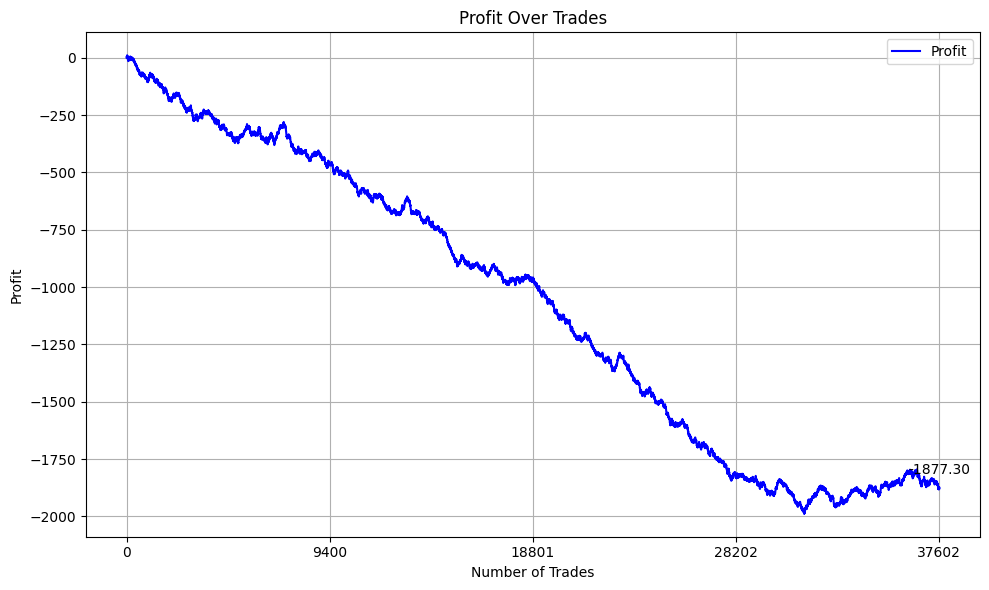

In [ ]:
import matplotlib.pyplot as plt


def simulate_profit(true_values):
    profit_per_trade = []

    for true in true_values:
        if true == 0:
            profit_per_trade.append(-1)
        elif true == 1:
            profit_per_trade.append(-1)
        elif true == 2:
            profit_per_trade.append(0.9)

    return profit_per_trade


profits = simulate_profit(y_test)


cumulative_profits = [sum(profits[:i+1]) for i in range(len(profits))]


plt.figure(figsize=(10, 6))
plt.plot(cumulative_profits, label="Profit", color="blue")
plt.xlabel("Number of Trades")
plt.ylabel("Profit")
plt.title("Profit Over Trades")
plt.xticks([0, len(cumulative_profits)//4, len(cumulative_profits)//2, 3*len(cumulative_profits)//4, len(cumulative_profits)-1])
plt.grid(True)
plt.legend()
plt.tight_layout()
final_profit = cumulative_profits[-1]
plt.annotate(f"{final_profit:.2f}", (len(cumulative_profits)-1, final_profit), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()



In [ ]:
def martingale_strategy(true_values, predictions):
    balance = 0
    bet = 1

    for i, true in enumerate(true_values):

        if true == 2 and predictions[i] == 2:
            balance += 0.9 * bet
            bet = 1

        else:
            balance -= bet
            bet *= 2

    return balance

predictions = [2 for _ in y_test]


final_balance = martingale_strategy(y_test, predictions)
print(f"Final Balance: {final_balance:.1f}")


Final Balance: -309528206.0


In [ ]:
def martingale_strategy(true_values, predictions):
    balance = 0
    bet = 1

    for i, true in enumerate(true_values):

        if true == 0 and predictions[i] == 0:  # 現在檢查是否實際和預測都是跌
            balance += 0.9 * bet
            bet = 1

        else:
            balance -= bet
            bet *= 2

    return balance

# 將所有預測值設為跌
predictions = [0 for _ in y_test]

final_balance = martingale_strategy(y_test, predictions)
print(f"Final Balance: {final_balance:.1f}")

Final Balance: -3480333183.4


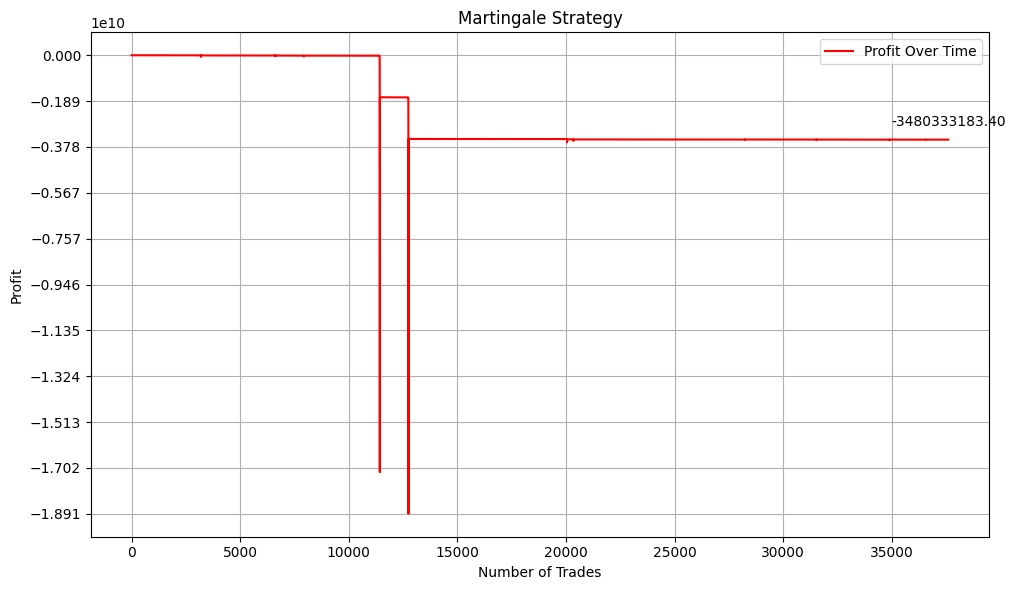

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def martingale_strategy(true_values):
    balances = []
    balance = 0
    bet = 1

    for i, true in enumerate(true_values):

        if true == 0:
            balance += 0.9 * bet
            bet = 1

        else:
            balance -= bet
            bet *= 2
        balances.append(balance)

    return balances

predictions = [2 for _ in y_test]
balances = martingale_strategy(y_test)

plt.figure(figsize=(10, 6))
plt.plot(balances, label="Profit Over Time", color="red")
plt.xlabel("Number of Trades")
plt.ylabel("Profit")
plt.title("Martingale Strategy")
plt.grid(True)
plt.legend()
plt.tight_layout()

min_balance = min(balances)
max_balance = max(balances)
yticks_interval = (max_balance - min_balance) / 10
plt.yticks(np.arange(min_balance, max_balance + yticks_interval, yticks_interval))

final_balance = balances[-1]
plt.annotate(f"{final_balance:.2f}", (len(balances)-1, final_balance), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


In [ ]:
def consecutive_non_decreases(true_values):
    count = 0
    max_count = 0
    for true in true_values:
        if true != 2:
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

max_consecutive_non_decreases = consecutive_non_decreases(y_test)
print(max_consecutive_non_decreases)


33
